In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import ttest_ind, shapiro, levene


In [54]:
df = pd.read_csv("Gender-Pay-Gap.csv")
df


,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319
...,...,...,...,...,...,...,...,...,...
995,Marketing Associate,Female,61,1,High School,Administration,1,62644,3270
996,Data Scientist,Male,57,1,Masters,Sales,2,108977,3567
997,Financial Analyst,Male,48,1,High School,Operations,1,92347,2724
998,Financial Analyst,Male,65,2,High School,Administration,1,97376,2225


In [55]:
# Check for missing values and drop rows with missing values (if any)
df = df.dropna()

# Remove duplicate rows
df = df.drop_duplicates()

# Ensure data types are correct (convert columns if necessary)
# For example, if 'Age' should be an integer, ensure it's correctly typed
df['Age'] = df['Age'].astype(int)

# Handle outliers (example: remove rows with BasePay or Bonus beyond a reasonable range)
df = df[(df['BasePay'] > 0) & (df['Bonus'] > 0)]

# Create Total Salary column by summing BasePay and Bonus
df['TotalSalary'] = df['BasePay'] + df['Bonus']

df['Dept'] = df['Dept'].astype('category')

# Standardize column names (optional, e.g., make all lowercase)
df.columns = df.columns.str.lower()

# Display the cleaned dataset
df

,jobtitle,gender,age,perfeval,education,dept,seniority,basepay,bonus,totalsalary
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938,52301
1,Software Engineer,Male,21,5,College,Management,5,108476,11128,119604
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268,99476
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154,118234
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319,108783
...,...,...,...,...,...,...,...,...,...,...
995,Marketing Associate,Female,61,1,High School,Administration,1,62644,3270,65914
996,Data Scientist,Male,57,1,Masters,Sales,2,108977,3567,112544
997,Financial Analyst,Male,48,1,High School,Operations,1,92347,2724,95071
998,Financial Analyst,Male,65,2,High School,Administration,1,97376,2225,99601


# Research Question 1

#### Is there a statistically significant difference in average salaries between male and female employees for the same job position?


In [56]:
# Filter job titles with both male and female employees
role_gender_counts = df.groupby(["jobtitle", "gender"]).size().unstack()
valid_roles = role_gender_counts.dropna().index.tolist()
filtered_df = df[df["jobtitle"].isin(valid_roles)]


In [ ]:
#  Analysis Loop
results = []

for role in valid_roles:
    sub_df = df[df["jobtitle"] == role]
    males = sub_df[sub_df["gender"] == "Male"]["basepay"]
    females = sub_df[sub_df["gender"] == "Female"]["basepay"]
    
    if len(males) > 1 and len(females) > 1:
        # Normality Test (Shapiro-Wilk)
        male_normal = shapiro(males)[1] > 0.05
        female_normal = shapiro(females)[1] > 0.05
        
        # Variance Equality (Levene’s Test)
        equal_var = levene(males, females)[1] > 0.05
        
        # Use Welch's t-test (default safe option)
        t_stat, p_val = ttest_ind(males, females, equal_var=False)
        pooled_std = np.sqrt((males.std()**2 + females.std()**2) / 2)
        cohen_d = (males.mean() - females.mean()) / pooled_std

        results.append({
            "JobTitle": role,
            "Male_Mean": round(males.mean(), 2),
            "Female_Mean": round(females.mean(), 2),
            "P-Value": round(p_val, 4),
            "Cohen_d": round(cohen_d, 3),
            "Male_Normal": male_normal,
            "Female_Normal": female_normal,
            "Equal_Variance": equal_var,
            "Test_Type": "Welch t-test"
        })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values("P-Value")
print("Gender Pay Analysis by Job Title:\n")
print(results_df)



Gender Pay Analysis by Job Title:

              JobTitle  Male_Mean  Female_Mean  P-Value  Cohen_d  Male_Normal  \
8    Software Engineer  106371.49     94701.00   0.1156    0.540         True   
0       Data Scientist   89222.63     95704.79   0.1405   -0.287         True   
9  Warehouse Associate   86553.43     92428.26   0.1856   -0.282         True   
1               Driver   91952.67     86867.63   0.2636    0.236         True   
6  Marketing Associate   81881.82     76119.18   0.4102    0.269         True   
7      Sales Associate   94663.12     91894.21   0.5539    0.122         True   
3     Graphic Designer   89595.80     92243.29   0.5703   -0.115         True   
5              Manager  124848.93    127252.28   0.6554   -0.116         True   
2    Financial Analyst   94607.03     95458.33   0.8401   -0.040         True   
4                   IT   91021.98     90475.72   0.9134    0.022         True   

   Female_Normal  Equal_Variance     Test_Type  
8           True        

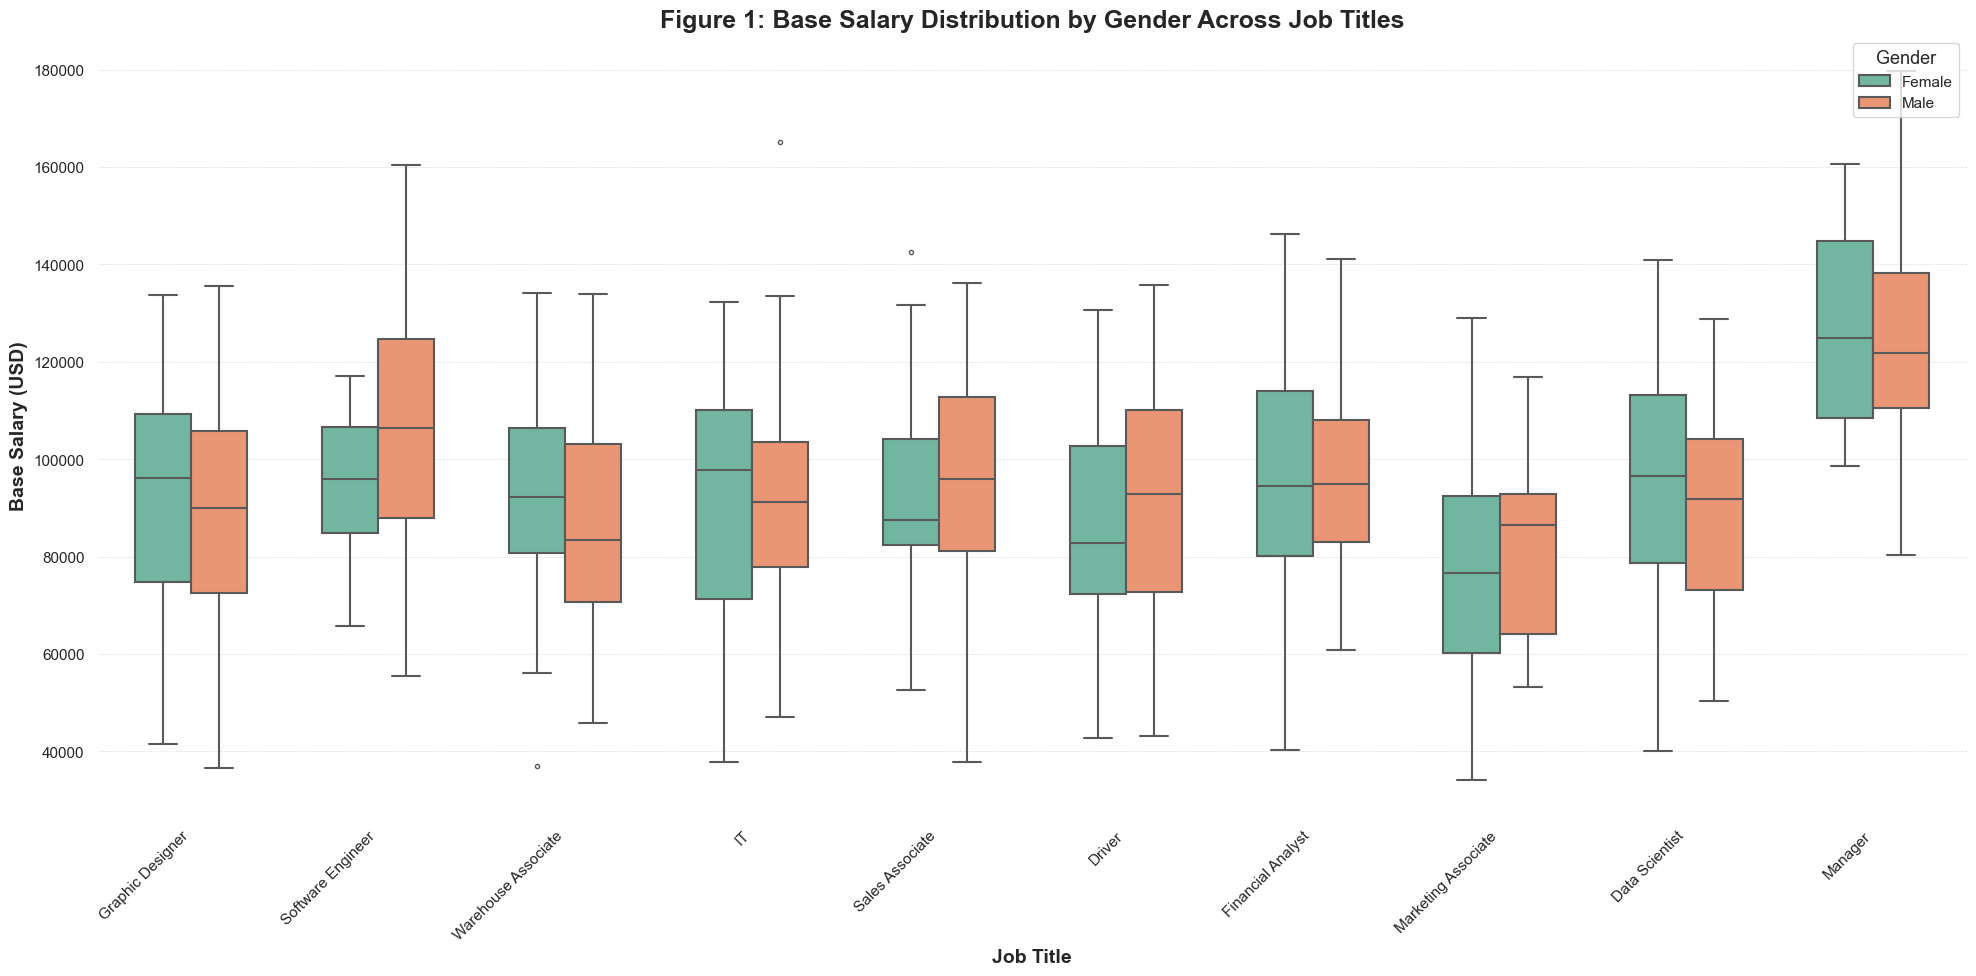

In [58]:

# Libraries already imported previously
sns.set(style="whitegrid", palette="Set2", font_scale=1.2)

plt.figure(figsize=(20, 10))
box = sns.boxplot(
    data=filtered_df,
    x="jobtitle",
    y="basepay",
    hue="gender",
    width=0.6,
    fliersize=3,
    linewidth=1.5
)

# Formatting
plt.title("Figure 1: Base Salary Distribution by Gender Across Job Titles", fontsize=18, fontweight='bold')
plt.xlabel("Job Title", fontsize=14, fontweight='bold')
plt.ylabel("Base Salary (USD)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Gender", title_fontsize=13, fontsize=11, loc='upper right')
plt.tight_layout()
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.box(False)

# Show the plot
plt.show()

# Research Question 2

### How do performance evaluation scores relate to overall compensation (base pay and bonus) for male versus female employees



In [59]:
# Create a new column for total compensation (base pay + bonus)
df['total_compensation'] = df['basepay'] + df['bonus']

# Encode gender as a binary variable (e.g., 0 for male, 1 for female)
df['gender_encoded'] = df['gender'].map({'Male': 0, 'Female': 1})

# Fit a multiple linear regression model
# Include performance evaluation scores, gender, and an interaction term between gender and performance scores
formula = 'total_compensation ~  perfeval + gender_encoded + perfeval:gender_encoded'
model = smf.ols(formula=formula, data=df).fit()

# Display the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_compensation   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     9.893
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           1.97e-06
Time:                        14:30:22   Log-Likelihood:                -11537.
No. Observations:                1000   AIC:                         2.308e+04
Df Residuals:                     996   BIC:                         2.310e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

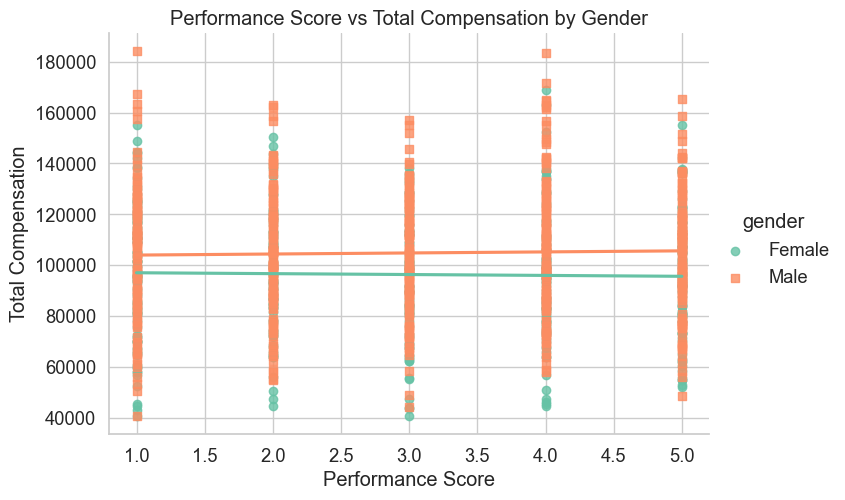

In [60]:
# Create a scatter plot with regression lines for each gender
sns.lmplot(
    x='perfeval', 
    y='total_compensation', 
    hue='gender', 
    data=df, 
    aspect=1.5, 
    markers=['o', 's'], 
    ci=None
)

# Add labels and title
plt.xlabel('Performance Score')
plt.ylabel('Total Compensation')
plt.title('Performance Score vs Total Compensation by Gender')
plt.show()

# RESEARCH QUESTION 3


How does the average base pay differ between male and female employees in various departments?

C:\Users\gauri\AppData\Local\Temp\ipykernel_55864\3601441753.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_base_pay = df.groupby(['dept', 'gender'])['basepay'].mean().unstack()
C:\Users\gauri\AppData\Local\Temp\ipykernel_55864\3601441753.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='dept', y='basepay', hue='gender', ci=None)



Average Base Pay by Department and Gender:
gender                Female           Male
dept                                       
Administration  87071.873684   96170.744898
Engineering     90774.955056  101433.000000
Management      92679.011494   99482.297297
Operations      86456.156250   93118.438596
Sales           92867.079208  102349.481132

Two-Way ANOVA Results:
                         sum_sq     df          F        PR(>F)
C(dept)            9.317056e+09    4.0   3.759494  4.827383e-03
C(gender)          1.803225e+10    1.0  29.104529  8.580222e-08
C(dept):C(gender)  6.059093e+08    4.0   0.244488  9.130447e-01
Residual           6.133727e+11  990.0        NaN           NaN


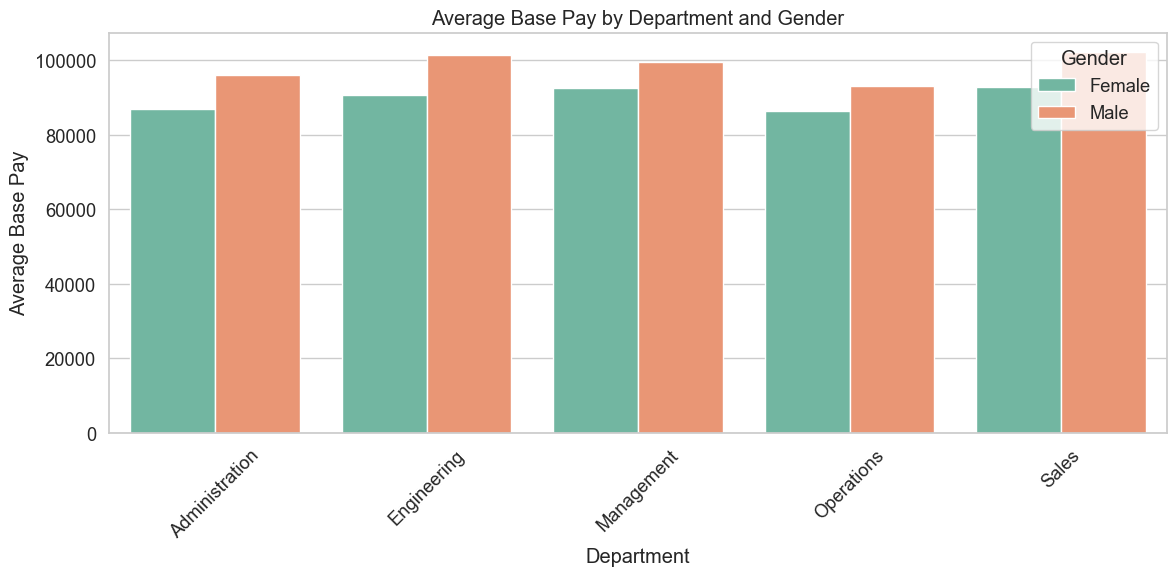

In [74]:
# Display basic group means
avg_base_pay = df.groupby(['dept', 'gender'])['basepay'].mean().unstack()
print("\nAverage Base Pay by Department and Gender:")
print(avg_base_pay)

# Perform Two-Way ANOVA
# Make sure Dept and Gender are categorical variables
df['dept'] = df['dept'].astype('category')
df['gender'] = df['gender'].astype('category')

# Build and fit the model
model = ols('basepay ~ C(dept) + C(gender) + C(dept):C(gender)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Show ANOVA results
print("\nTwo-Way ANOVA Results:")
print(anova_table)

# Visualization: Average BasePay by Department and Gender
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='dept', y='basepay', hue='gender', ci=None)
plt.title('Average Base Pay by Department and Gender')
plt.xlabel('Department')
plt.ylabel('Average Base Pay')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()



# RESEARCH QUESTION 4


#### Does the gender pay gap persist after controlling for experience, education, and job level? 

In [61]:
# ------------------ Multiple Linear Regression ------------------
# Fit the MLR model
# We'll use gender, job level (seniority), age, and department to predict salary
model = ols('total_compensation ~ C(gender) + C(seniority) + age + C(dept)', data=df).fit()

In [62]:
# Display summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_compensation   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     168.1
Date:                Sat, 26 Apr 2025   Prob (F-statistic):          1.93e-205
Time:                        14:30:23   Log-Likelihood:                -11055.
No. Observations:                1000   AIC:                         2.213e+04
Df Residuals:                     989   BIC:                         2.219e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.36

In [63]:
# ------------------ Assumption Checks ------------------

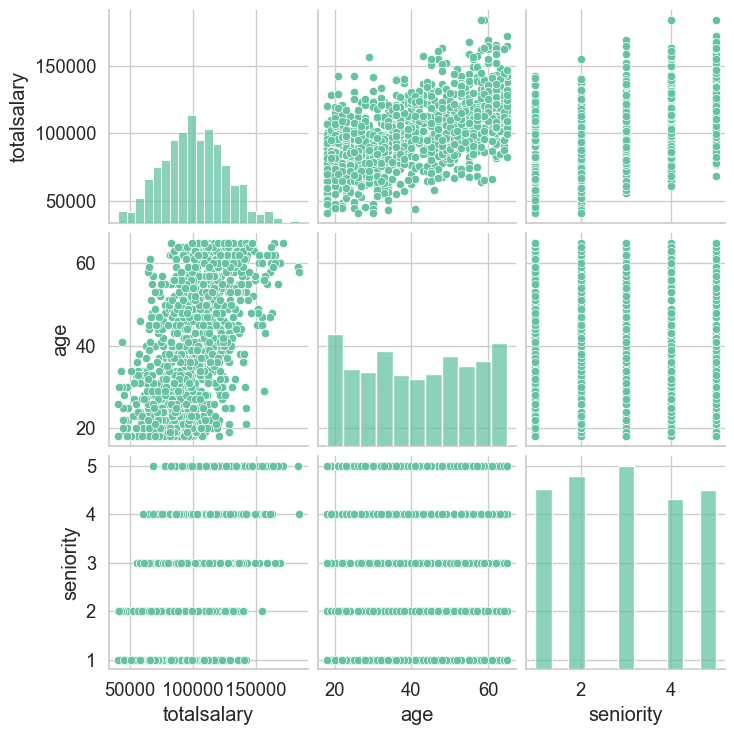

In [64]:

# 1. Linearity: Check via scatterplot of each independent variable vs TotalSalary
sns.pairplot(df[['totalsalary', 'age', 'seniority', 'gender']])
plt.show()

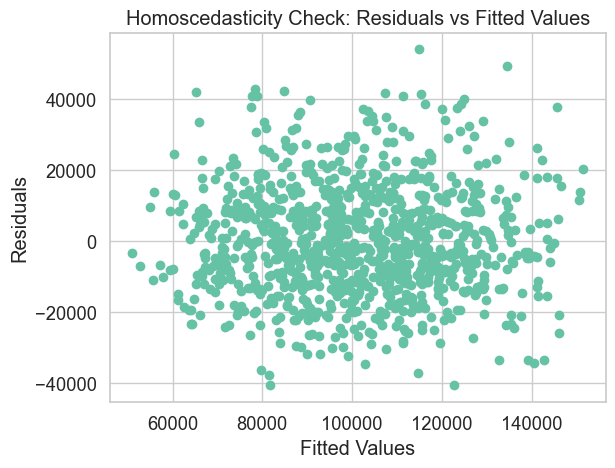

In [65]:
# 2. Homoscedasticity: Plot residuals vs fitted values
fitted_vals = model.fittedvalues
residuals = model.resid
plt.scatter(fitted_vals, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check: Residuals vs Fitted Values')
plt.show()

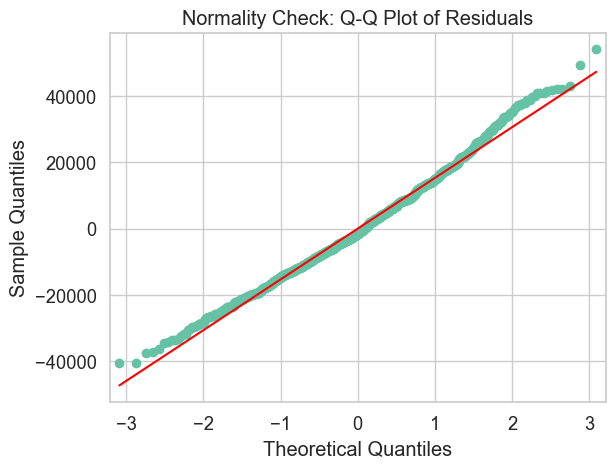

In [66]:
# 3. Normality of residuals: Use Q-Q plot
qqplot(residuals, line='s')
plt.title('Normality Check: Q-Q Plot of Residuals')
plt.show()

In [67]:
# Perform the normality test (Anderson-Darling test for residuals)
ad_statistic, ad_significance_level = normal_ad(residuals)
print(f"Normality Test (Anderson-Darling) Statistic: {ad_statistic}, Significance Level: {ad_significance_level}")


Normality Test (Anderson-Darling) Statistic: 2.1720007491018123, Significance Level: 1.6245396971697394e-05


In [68]:

# ------------------ Post-Hoc Test (if Gender is significant) ------------------
# If gender is significant, we can explore its interaction with job level or age
# For simplicity, assume gender is significant, and we can run interaction terms
interaction_model = ols('totalsalary ~ C(gender) * C(seniority) + age + C(dept)', data=df).fit()


In [69]:
# ANOVA table for the interaction model
anova_results = anova_lm(interaction_model, typ=2)
print("\nANOVA Results for Interaction Model:")
print(anova_results)


ANOVA Results for Interaction Model:
                              sum_sq     df           F         PR(>F)
C(gender)               2.453898e+10    1.0  103.620103   3.292170e-23
C(seniority)            1.878164e+11    4.0  198.271855  1.021372e-124
C(dept)                 6.426574e+09    4.0    6.784331   2.184519e-05
C(gender):C(seniority)  8.819225e+08    4.0    0.931018   4.451051e-01
age                     1.900921e+11    1.0  802.697040  1.233196e-129
Residual                2.332645e+11  985.0         NaN            NaN


# Research Question 5

#### How does the gender pay gap evolve with seniority levels in the workplace?


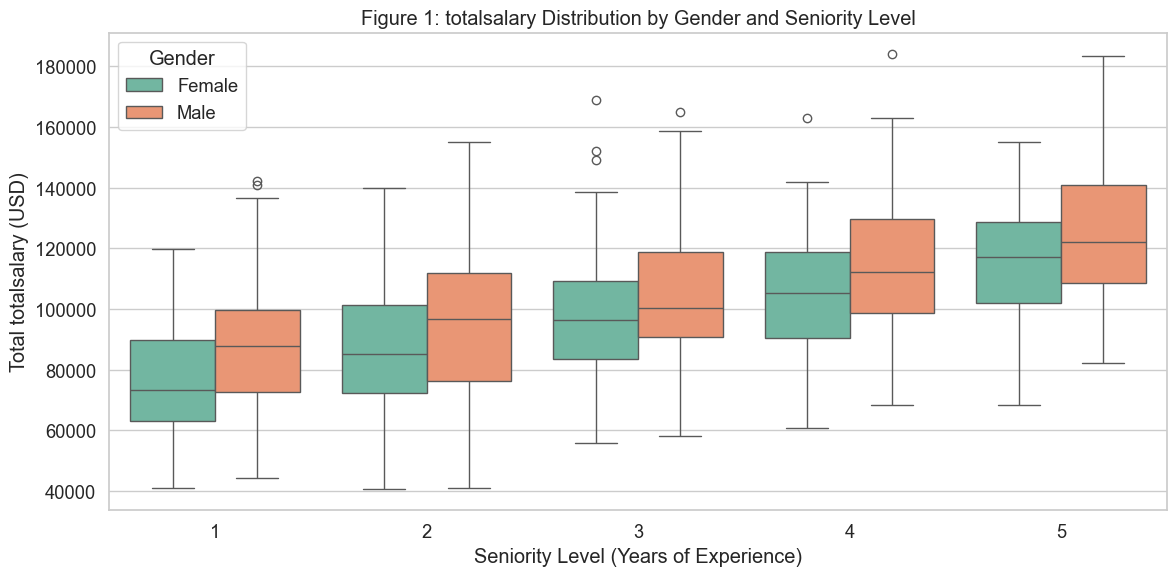

In [ ]:
# Convert gender and seniority to categorical
df['gender'] = df['gender'].astype('category')
df['seniority'] = df['seniority'].astype('category')

# --------------------------------------
# Figure 1: Boxplot of Salary by Gender and Seniority
# --------------------------------------

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='seniority', y='totalsalary', hue='gender')
plt.title('Figure 1: totalsalary Distribution by Gender and Seniority Level')
plt.xlabel('Seniority Level (Years of Experience)')
plt.ylabel('Total totalsalary (USD)')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()





In [71]:
# --------------------------------------
# Two-Way ANOVA: Gender, Seniority, and Their Interaction
# --------------------------------------

model = ols('totalsalary ~ C(gender) * C(seniority)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Two-Way ANOVA Table:\n")
print(anova_table)


Two-Way ANOVA Table:

                              sum_sq     df           F        PR(>F)
C(gender)               2.120452e+10    1.0   48.612809  5.691374e-12
C(seniority)            1.813187e+11    4.0  103.921404  6.356250e-74
C(gender):C(seniority)  1.076580e+09    4.0    0.617034  6.504556e-01
Residual                4.318300e+11  990.0         NaN           NaN


C:\Users\gauri\AppData\Local\Temp\ipykernel_55864\641519993.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_salary = df.groupby(['seniority', 'gender'])['totalsalary'].mean().unstack()


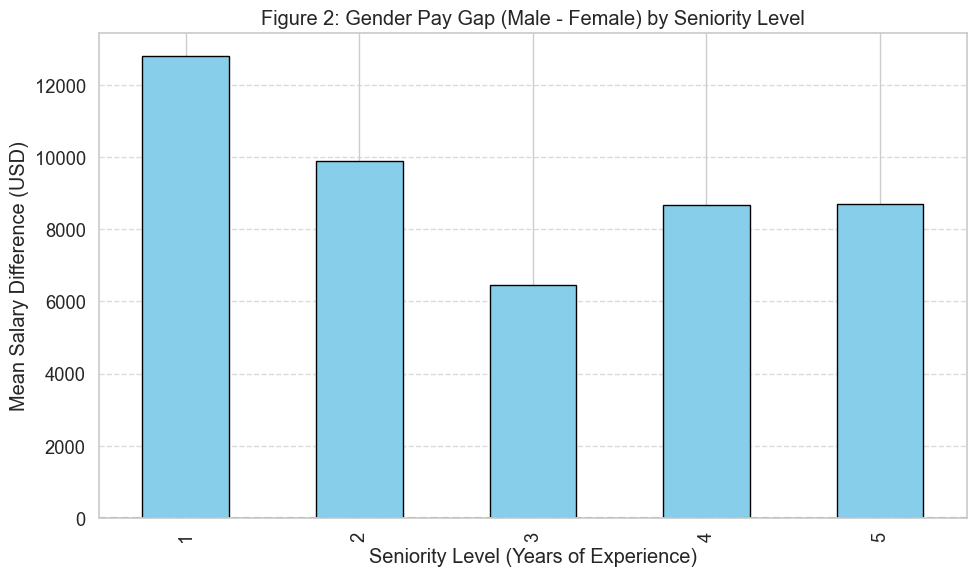

In [72]:
# --------------------------------------
# Figure 2: Bar Chart of Gender Pay Gap (Male - Female) by Seniority Level
# --------------------------------------

# Calculate mean salary by gender and seniority
mean_salary = df.groupby(['seniority', 'gender'])['totalsalary'].mean().unstack()

# Ensure column names are standard strings
mean_salary.columns = mean_salary.columns.astype(str)

# Compute the gender pay gap
mean_salary['gap'] = mean_salary['Male'] - mean_salary['Female']

# Plot the gender pay gap
plt.figure(figsize=(10, 6))
mean_salary['gap'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Figure 2: Gender Pay Gap (Male - Female) by Seniority Level')
plt.xlabel('Seniority Level (Years of Experience)')
plt.ylabel('Mean Salary Difference (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [73]:
# --------------------------------------
# Posthoc Analysis: Tukey's HSD Test
# --------------------------------------

# Create a new group variable combining gender and seniority
df['group'] = df['gender'].astype(str) + "_" + df['seniority'].astype(str)

# Run Tukey's HSD test on salary by group
tukey = pairwise_tukeyhsd(endog=df['totalsalary'], groups=df['group'], alpha=0.05)

print("\nTukey's HSD Posthoc Test Results:\n")
print(tukey)


Tukey's HSD Posthoc Test Results:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1   group2    meandiff  p-adj     lower       upper    reject
-------------------------------------------------------------------
Female_1 Female_2  10163.3173 0.0345    373.4817  19953.1528   True
Female_1 Female_3  22222.7921    0.0  12516.1819  31929.4023   True
Female_1 Female_4  30533.5881    0.0  20157.3859  40909.7903   True
Female_1 Female_5   40704.496    0.0  30802.1065  50606.8855   True
Female_1   Male_1  12810.8827  0.001   3219.1314  22402.6341   True
Female_1   Male_2  20043.1553    0.0  10356.4847  29729.8259   True
Female_1   Male_3  28692.1816    0.0   19118.512  38265.8511   True
Female_1   Male_4  39219.2179    0.0  29471.7065  48966.7293   True
Female_1   Male_5  49413.7027    0.0  39487.5599  59339.8455   True
Female_2 Female_3  12059.4748 0.0014   2873.8794  21245.0703   True
Female_2 Female_4  20370.2708    0.0  10479.7473  30260.7943   True
Female_2 Fem